# Creación de Imágenes Temporales Asociadas a una Frecuencia de Muestreo Específica
Una vez creado los dos datasets, que contienen información sobre los valores de fisura y los valores de perno flojo respectivamente, tenemos como objetivo obtener para cada conjunto de datos un subconjunto de datos correspondiente a una frecuencia dada.

Esto es debido a que la frecuencia de muestreo utilizada por los sensores representa un valor muy elevado en comparación a la frecuencia de los dispositivos empleados en la realidad para las turbinas de tipo jacket. Por eso, se tiene previsto capturar un datos cada 6 muestras para que el muestreo sea más similar a los mencionados previamente.

Una vez obtenido los datos con el step de 6 para cada dataset (fisura y perno flojo), se deben generar imágenes con las dimensiones: 
* (24, 16, 16)

Para cada experimento vamos a generar múltiples imágenes por cada columna dentro del subconjunto de datos obtenido previamente (step de 6). Estas imágenes estarán relacionadas con las columnas adyacentes para establecer una relación temporal entre las capas creadas de cada imagen (24 capas).

La forma en cómo se obtienen estas imágenes es la siguiente:
- Tenemos un experimento de 99097 muestras, en donde debemos adquirir un subconjunto a partir de un salto de 6 elementos por cada muestra.
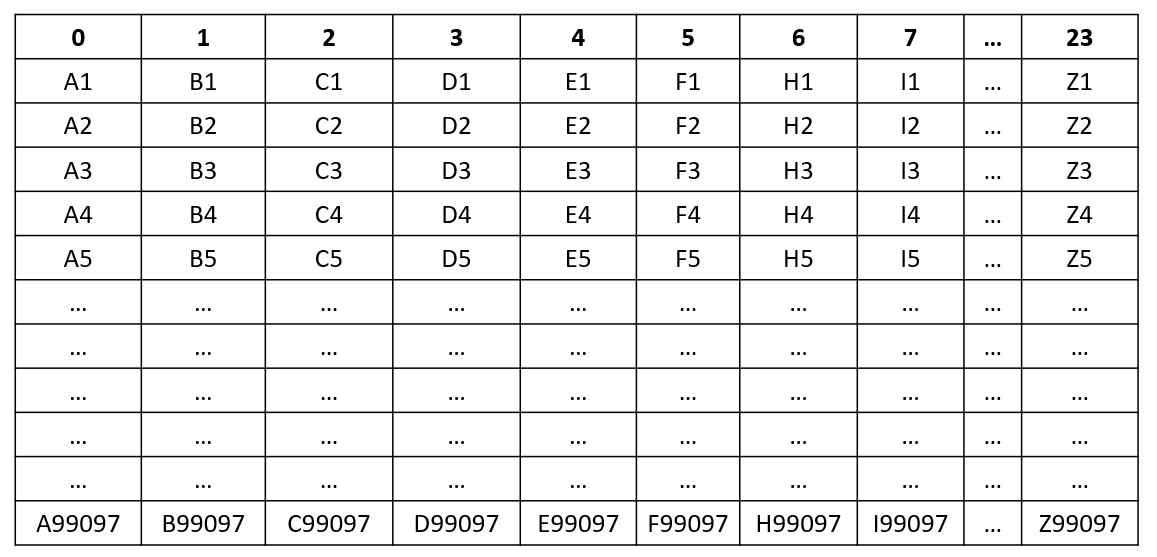
- Se obtienen 256 valores de manera continua a lo largo de cada columna.
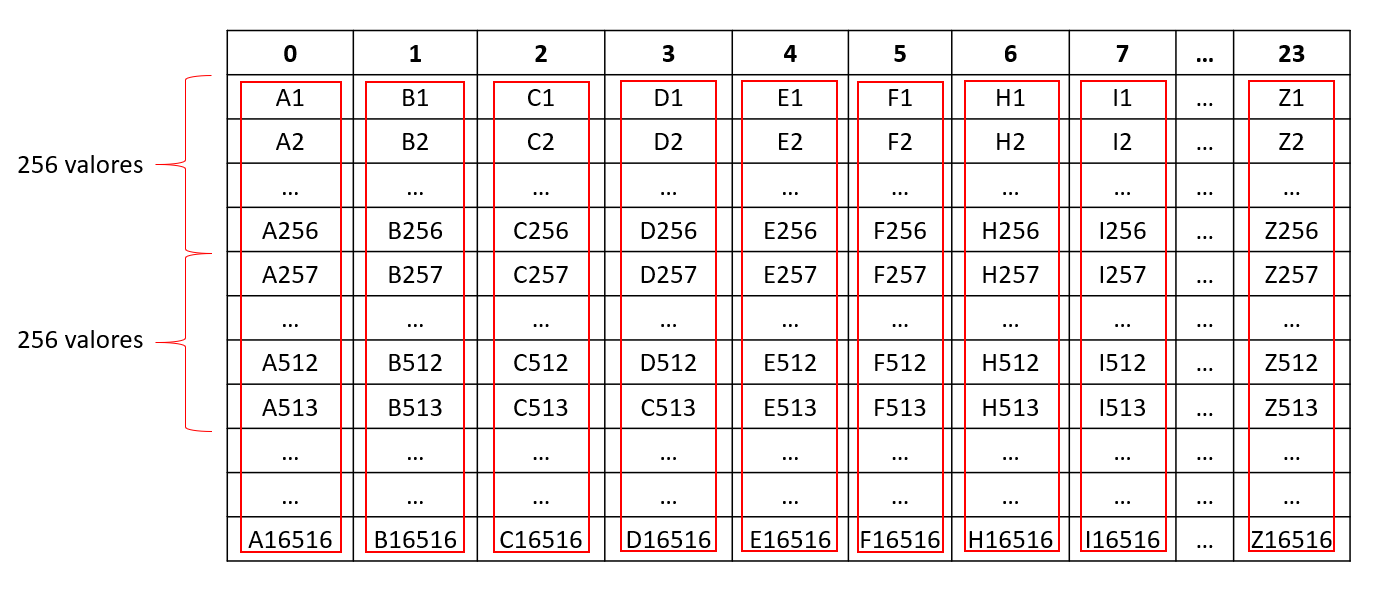
- Ahora para cada conjunto de 256 valores continuos aplicamos un redimensionamiento para obtener una capa 16x16.
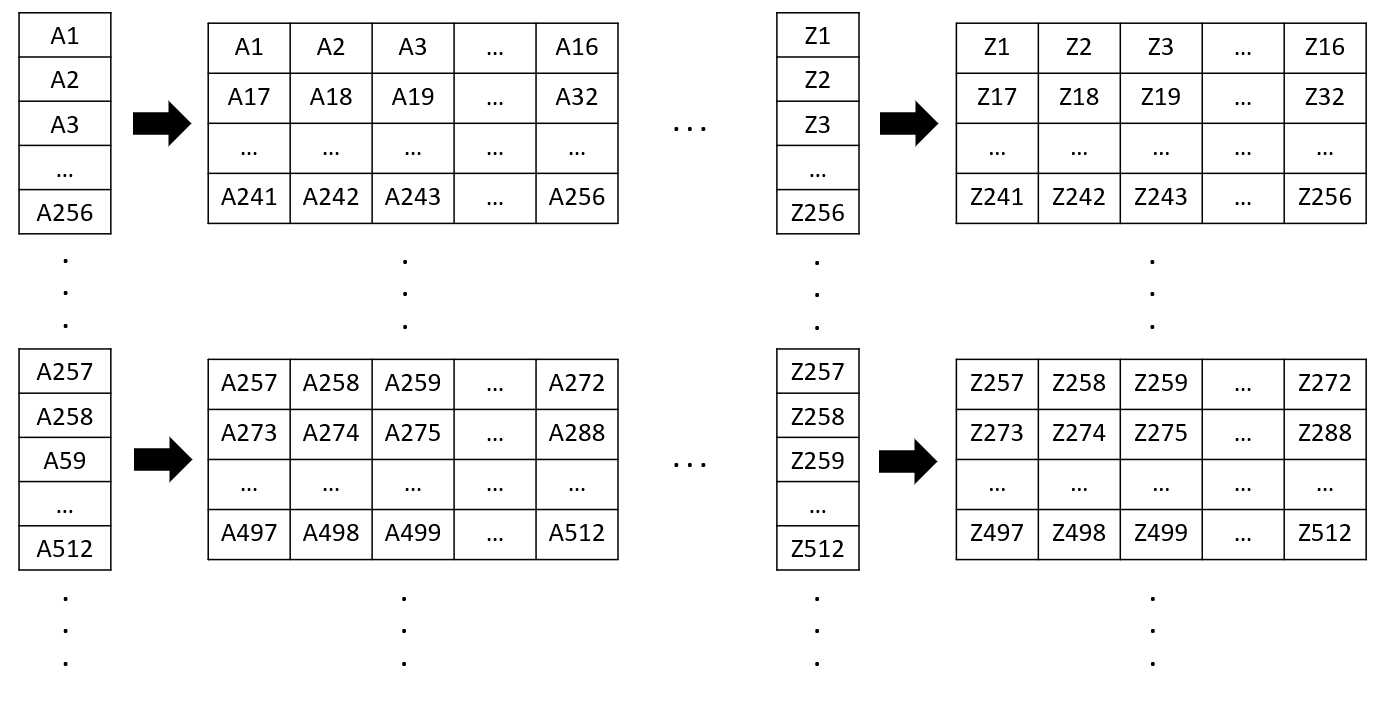 
- Las capas de cada columna que comparten el mismo índice dentro de los datos son colocadas en un arreglo, y a este arreglo lo denominaremos la imagen obtenida.
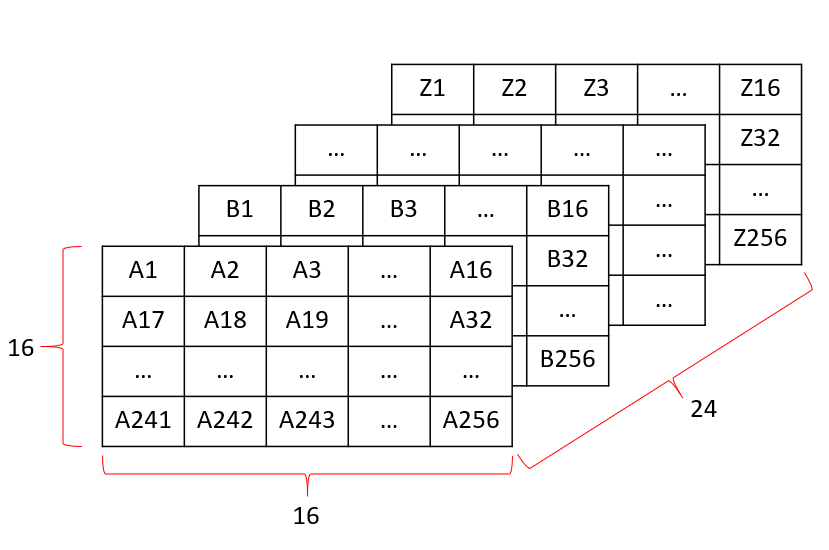

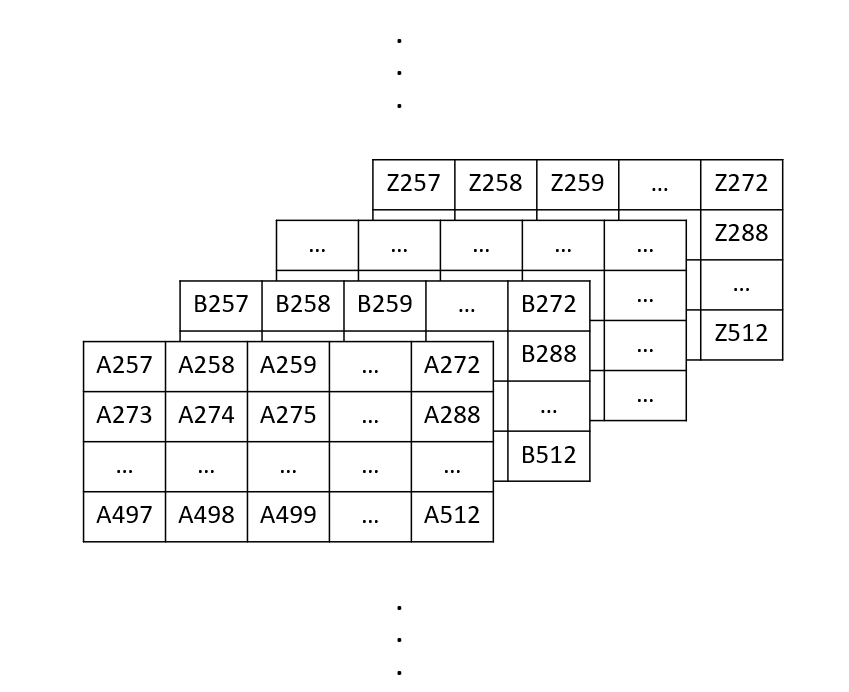

Este formato va a ser útil para la creación de pares positivos y negativos dentro de una red neuronal siamesa (SNN), la cual se va a elaborar posteriormente en otro notebook de Google Colab.

## Importaciones
Realizamos las importaciones necesarias para poder manipular el dataset original y crear las imágenes correspondientes previamente mencionadas.

In [1]:
from google.colab import drive
from os import listdir
from os.path import isfile, join
from scipy.io import loadmat
from random import randint

import pandas as pd
import numpy as np
import random

import os

## Obtención de Datos
Se obtienen los conjuntos de datos relacionados a fisura y perno flojo, todos los experimentos y todos los niveles de white noise.

In [2]:
# Establecemos conexión con Google Drive para acceder al dataset general
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Guardamos la dirección del dataset en una variable para utilizala posteriormente
dataset_datos_dir = 'drive/MyDrive/DATOS_EXPERIMENTALES_JACKET/DATOS'

In [4]:
# Obtenemos una lista con todos los nombres de los archivos relacionados a los experimentos realizados
dataset_datos_files = [dataset_datos_dir+'/'+filename for filename in listdir(dataset_datos_dir) if isfile(join(dataset_datos_dir, filename))]

In [5]:
# Creamos listas en donde se almacenarán los archivos relacionados a experimentos de fisura y experimentos de perno flojo respectivamente
datos_fisura = []
datos_pernoflojo = []

# Iteramos los nombres de todos los archivos en la lista general previamente creada
for filename in listdir(dataset_datos_dir):
  # Obtenemos el nombre del archivo tal cual, sin direcciones previas
  if isfile(join(dataset_datos_dir, filename)):
    nombre_archivo = filename.split('.')[0]
    # El estado de fisura se asocia al número 3 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_fisura
    if (nombre_archivo.split('_')[0] == '3'):
      datos_fisura.append(dataset_datos_dir + '/' + filename)
    # El estado de fisura se asocia al número 4 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_pernoflojo
    elif (nombre_archivo.split('_')[0] == '4'):
      datos_pernoflojo.append(dataset_datos_dir + '/' + filename)

### Dataset de Fisura
Anteriormente se creó una lista con los nombres de los archivos, pero no tenemos un conjunto de archivos con datos crudos en sí, por lo que en esta sección se va a realizar dicho trabajo. Además, se pretende agregar columnas asociadas con el número de experimento y el nivel de white noise para no mezclar los datos al momento de realizar las imágenes.

In [6]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_fisura = []
amplitud_experimentos_fisura = []

# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_fisura:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_fisura creada anteriormente
  numero_experimentos_fisura.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_fisura creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_fisura.append(amplitud_experimento)
  else:
    amplitud_experimentos_fisura.append(int(amplitud_experimento))

In [7]:
# Creamos un DataFrame vacío
df_fisura = pd.DataFrame()

# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_fisura)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_fisura[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_fisura[indice]
  df['amplitud'] = amplitud_experimentos_fisura[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_fisura = pd.concat([df_fisura, df], axis = 0)

In [26]:
# Revisamos el conjunto de datos obtenido para fisura
df_fisura.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000132,0.000185,0.000122,0.000105,0.000141,0.000075,0.000007,0.000231,0.000299,0.000113,0.000228,0.000225,0.000168,0.000018,0.000344,0.000275,-0.000017,0.000046,0.000200,0.000169,0.000097,0.000196,-0.000053,0.000018,1,1.0
1,0.000092,0.000223,0.000166,0.000127,0.000191,0.000137,0.000075,0.000192,0.000240,0.000095,0.000279,0.000231,0.000145,0.000037,0.000339,0.000092,0.000085,0.000074,0.000128,0.000163,0.000074,0.000085,0.000063,-0.000027,1,1.0
2,0.000091,0.000280,0.000188,0.000130,0.000172,0.000102,0.000161,0.000158,0.000211,0.000123,0.000269,0.000206,0.000198,0.000041,0.000312,0.000179,0.000011,0.000079,0.000117,0.000146,0.000085,0.000089,-0.000014,0.000020,1,1.0
3,0.000179,0.000199,0.000249,0.000102,0.000268,0.000140,0.000126,0.000231,0.000239,0.000102,0.000284,0.000175,0.000164,0.000082,0.000311,0.000235,0.000031,0.000079,0.000257,0.000110,0.000050,0.000120,0.000080,0.000057,1,1.0
4,0.000282,0.000277,0.000202,0.000211,0.000251,0.000159,0.000096,0.000205,0.000342,0.000113,0.000240,0.000272,0.000214,0.000057,0.000304,0.000302,0.000047,0.000150,0.000271,0.000168,0.000126,0.000224,0.000105,0.000058,1,1.0
5,0.000005,0.000196,0.000247,0.000109,0.000186,0.000115,0.000042,0.000129,0.000255,0.000108,0.000315,0.000214,0.000237,-0.000001,0.000334,0.000202,-0.000008,0.000081,0.000173,0.000165,0.000126,0.000107,-0.000012,0.000006,1,1.0
6,0.000176,0.000372,0.000223,0.000154,0.000258,0.000165,0.000170,0.000157,0.000228,0.000126,0.000282,0.000219,0.000198,0.000081,0.000333,0.000146,0.000065,0.000070,0.000140,0.000145,0.000099,0.000115,0.000068,-0.000031,1,1.0
7,0.000133,0.000171,0.000187,0.000182,0.000237,0.000159,0.000121,0.000280,0.000293,0.000096,0.000248,0.000202,0.000160,0.000015,0.000319,0.000335,-0.000004,0.000102,0.000201,0.000193,0.000180,0.000171,-0.000009,0.000095,1,1.0


In [9]:
# Si dividimos para 99097 el df_fisura deberíamos obtener 20 experimentos en total
len(df_fisura)/99097

20.0

#### Procesamiento de Datos
En esta sección, nos enfocaremos en obtener las imágenes mencionadas en la introducción del notebook y verificar si las imágenes se generaron correctamente. Debemos tener en cuenta que sólo es posible generar 64 imágenes por experimento individual debido a la longitud de las columnas, y que sólo se tienen 20 experimentos por dataset (ya sea fisura o perno flojo).

Cuando nos vayamos a referir a imágenes, estaremos hablando de imágenes 16x16 o de imágenes 24x16x16 (se va a especificar cuál de las dos en los comentarios).

In [10]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimento = [1, 2, 3, 4, 5]
wn = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento = []

# Iteramos por experimento y por nivel de white noise
for i in experimento:
  for j in wn:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_fisura["#_exp"] == i
    filter2 = df_fisura["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_fisura.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento.append(arreglo_matrices_asociadas)

Lo que se realizó en el anterior código fue lo siguiente para cada archivo de experimento individual:
- Se obtuvieron las imágenes tal y como se mencionó en la introducción de este notebook.
- Todas las imágenes 16x16 asociadas a una columna fueron guardadas en una lista (lo mismo se realizó para las demás columnas del mismo experimento individual).
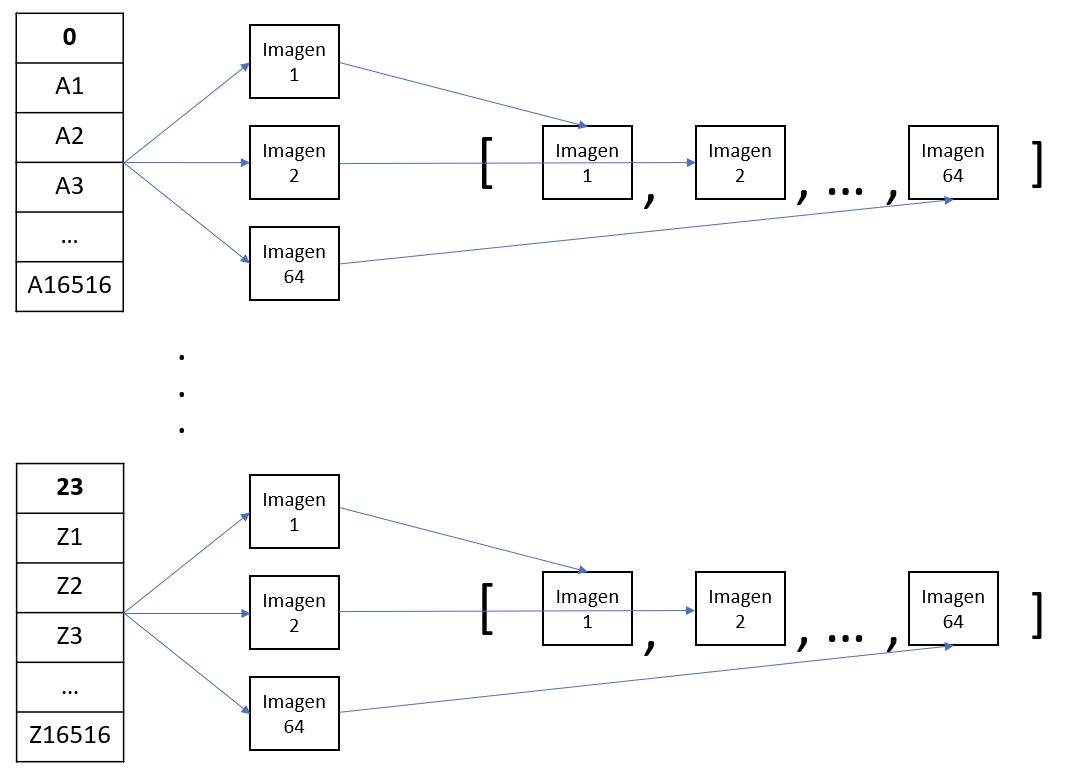
- Las listas de imágenes (16x16) por columna fueron almacenadas en una lista que asocia todas estas listas a un solo experimento individual.
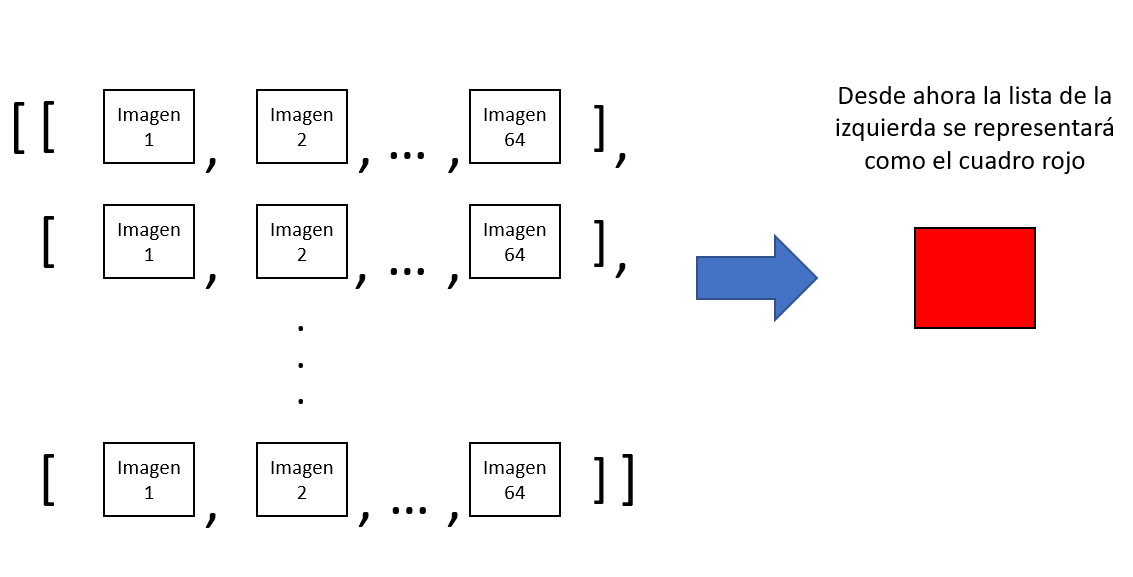
- Cada una de estas listas, en donde se representa un experimento único por cada una de estas, fueron almacenadas en una lista general denominada arreglo_imagenes_por_experimento.
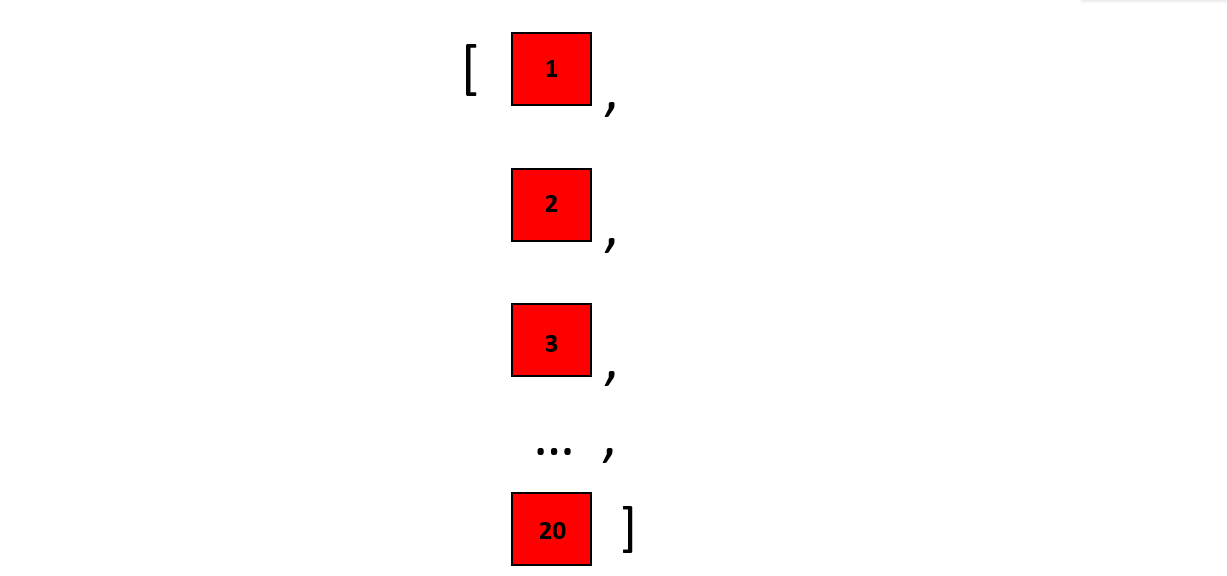

Ahora verificamos algunas dimensiones.

In [11]:
len(arreglo_imagenes_por_experimento)

20

In [12]:
len(arreglo_imagenes_por_experimento[0])

24

In [13]:
len(arreglo_imagenes_por_experimento[0][0])

64

In [14]:
arreglo_imagenes_por_experimento[0][0][0].size

256

In [15]:
arreglo_imagenes_por_experimento[0][0][0].shape

(16, 16)

Básicamente lo que tenemos es una lista que posee 20 experimentos, cada experimento posee 24 listas y cada lista posee 64 imágenes, en donde cada imagen tien 256 elementos en un diomensionamiento de 16x16. 

Sin embargo, todavía no hemos creado las imágenes de dimensión (24, 16, 16) porque las imágenes de (16, 16) deberían estar relacionadas de la siguiente manera:
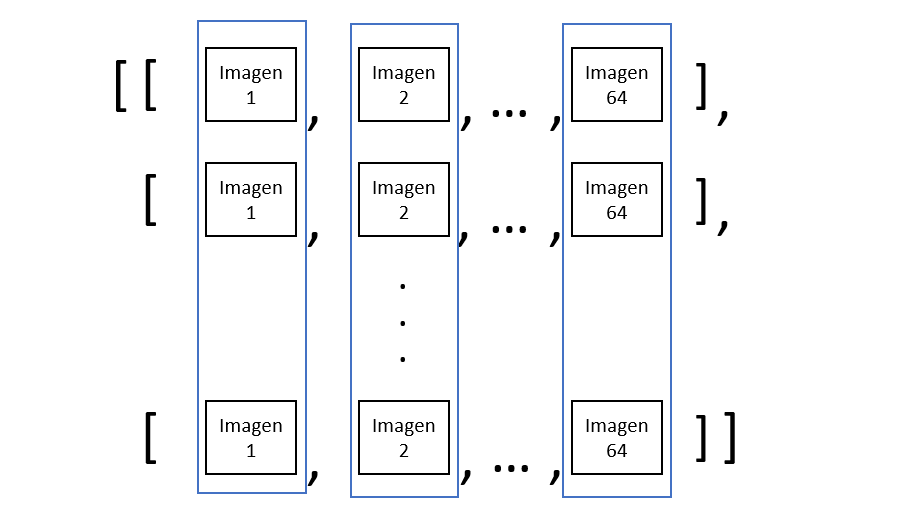


Ahora vamos a crear las imágenes de dimensionamiento (24, 16, 16) como corresponde.

In [11]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento in arreglo_imagenes_por_experimento:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes.append(np.array(imagen))

Ahora, como en cada experimento se pueden obtener 64 imágenes (16x16) y tenemos 20 experimentos por dataset (en este caso el de fisura), entonces deberíamos tener 1280 imágenes en total de dimensionamiento (24, 16, 16).

In [12]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes) 

1280

In [13]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen = randint(0, len(arreglo_imagenes) - 1)
arreglo_imagenes[indice_imagen].shape, type(arreglo_imagenes[0]), indice_imagen

((24, 16, 16), numpy.ndarray, 895)

#### Verificación
Vamos a verificar que las imágenes creadas corresponden a los datos dentro del df_fisura. Para esto se van a generar 2 funciones, una para obtener una sola imagen dentro del dataset asociado a fisura (imagen_2), y otra para que a partir de los datos de la primera imagen se obtenga la imagen correspondiente dentro de la lista de imágenes arreglo_imagenes (imagen_1).

La conexión entre estas dos imágenes se basa en que los datos en arreglo_imagenes fueron creados de manera secuencial.

In [69]:
# Establecemos los valores correspondientes a variables que nos van a ayudar con la localización de la imagen a comparar.
prueba_exp = random.choice(experimento) # número de experimento
prueba_wn = random.choice(wn) # nivel de white noise
prueba_n = random.randint(1, 64) # índice de la imagen creada por experimento (en cada experimento individual se crean 64 imágenes)

In [67]:
# Creamos un diccionario que nos va a ayudar a relacionar la primera imagen con la segunda imagen
diccionario = {}
rango_inferior = 1
rango_superior = 64

# Creamos claves basados en el número de experimento y el nivel de white noise, en donde la clave será el intervalo en donde se encuentra la imagen 1
# a partir de los datos de la imagen 2
for i in experimento:
  for j in wn:
    diccionario[(i, j)] = [rango_inferior, rango_superior]
    rango_inferior = rango_inferior + 64
    rango_superior = rango_superior + 64

In [68]:
# Verificamos que las claves y valores del diccionario se hayan creado correctamente
diccionario

{(1, 0.5): [1, 64],
 (1, 1): [65, 128],
 (1, 2): [129, 192],
 (1, 3): [193, 256],
 (2, 0.5): [257, 320],
 (2, 1): [321, 384],
 (2, 2): [385, 448],
 (2, 3): [449, 512],
 (3, 0.5): [513, 576],
 (3, 1): [577, 640],
 (3, 2): [641, 704],
 (3, 3): [705, 768],
 (4, 0.5): [769, 832],
 (4, 1): [833, 896],
 (4, 2): [897, 960],
 (4, 3): [961, 1024],
 (5, 0.5): [1025, 1088],
 (5, 1): [1089, 1152],
 (5, 2): [1153, 1216],
 (5, 3): [1217, 1280]}

In [70]:
def crear_subconjunto_prueba(prueba_exp, prueba_wn):
  """
  Creamos el subconjunto de paso 6 a partir del dataset ingresado
  """
  prueba_filtro_1 = df_fisura["#_exp"] == prueba_exp
  prueba_filtro_2 = df_fisura["amplitud"] == prueba_wn
  prueba_subconjunto_experimento = df_fisura.where(prueba_filtro_1 & prueba_filtro_2).dropna()

  prueba_subconjunto_paso6 = prueba_subconjunto_experimento[::6]

  return prueba_subconjunto_paso6

In [71]:
# Guardamos el subconjunto creado en una variable
prueba_subconjunto_paso6 = crear_subconjunto_prueba(prueba_exp=prueba_exp, prueba_wn=prueba_wn)

Debemos tener en cuentra que para poder comparar ambas imágenes, las dos deben haber pasado por el mismo procesamiento (llevar a 24x16x16).

In [72]:
def crear_imagen_comparacion(prueba_n, prueba_subconjunto_paso_6):
  """
  Creamos la imagen_2 para la comparación
  """
  inicio = (prueba_n - 1)*256
  fin = prueba_n*256

  imagen = prueba_subconjunto_paso6[inicio:fin]
  matriz = []

  for i in range(24):
    matriz.append(imagen[i].to_numpy().reshape((16, 16)))
  
  return np.array(matriz)

In [78]:
def obtener_imagen_original(prueba_exp, prueba_wn, diccionario, arreglo_imagenes,prueba_n):
  """
  Obtención de imagen_1 asociada a los parámetros escogidos para la imagen_2
  """
  rango = diccionario[(prueba_exp, prueba_wn)]

  return arreglo_imagenes[rango[0]-1:rango[1]-1][prueba_n-1]

In [83]:
# Almacenamos las imágenes en sus respectivas variables
imagen_1 = obtener_imagen_original(prueba_exp, prueba_wn, diccionario, arreglo_imagenes, prueba_n)
imagen_2 = crear_imagen_comparacion(prueba_n, prueba_subconjunto_paso6)

In [89]:
# Chequeamos los parámetros creados para ambas imágenes
print("Número de experimento: ", prueba_exp)
print("Nivel de White Noise:  ", prueba_wn)
print("Número de imagen:      ", prueba_n)

Número de experimento:  1
Nivel de White Noise:   0.5
Número de imagen:       1


In [85]:
# Verificamos si la imagen_1 es igual a la imagen_2
(imagen_1 == imagen_2).all()

True

In [91]:
imagen_1

array([[[ 1.39461600e-04,  1.08933600e-04,  1.46177760e-04, ...,
          9.85540800e-05,  1.34577120e-04,  1.64494560e-04],
        [ 1.49230560e-04,  1.35798240e-04,  1.38240480e-04, ...,
          6.49732800e-05,  9.18379200e-05,  1.19923680e-04],
        [ 1.78537440e-04,  1.45567200e-04,  1.41903840e-04, ...,
          1.66326240e-04,  1.29082080e-04,  1.62662880e-04],
        ...,
        [ 1.76095200e-04,  1.22976480e-04,  1.12596960e-04, ...,
          1.66936800e-04,  6.86366400e-05,  1.46788320e-04],
        [ 1.20534240e-04,  1.75484640e-04,  1.13207520e-04, ...,
          1.59610080e-04,  1.41903840e-04,  1.27250400e-04],
        [ 9.48907200e-05,  1.16260320e-04,  1.81590240e-04, ...,
          1.69379040e-04,  1.94412000e-04,  8.81745600e-05]],

       [[ 2.79792598e-04,  2.48714320e-04,  2.59073746e-04, ...,
          2.29823602e-04,  2.30432980e-04,  2.62730014e-04],
        [ 2.40792406e-04,  2.31651736e-04,  2.57854990e-04, ...,
          2.18245420e-04,  2.38964272e

In [87]:
imagen_2

array([[[ 1.39461600e-04,  1.08933600e-04,  1.46177760e-04, ...,
          9.85540800e-05,  1.34577120e-04,  1.64494560e-04],
        [ 1.49230560e-04,  1.35798240e-04,  1.38240480e-04, ...,
          6.49732800e-05,  9.18379200e-05,  1.19923680e-04],
        [ 1.78537440e-04,  1.45567200e-04,  1.41903840e-04, ...,
          1.66326240e-04,  1.29082080e-04,  1.62662880e-04],
        ...,
        [ 1.76095200e-04,  1.22976480e-04,  1.12596960e-04, ...,
          1.66936800e-04,  6.86366400e-05,  1.46788320e-04],
        [ 1.20534240e-04,  1.75484640e-04,  1.13207520e-04, ...,
          1.59610080e-04,  1.41903840e-04,  1.27250400e-04],
        [ 9.48907200e-05,  1.16260320e-04,  1.81590240e-04, ...,
          1.69379040e-04,  1.94412000e-04,  8.81745600e-05]],

       [[ 2.79792598e-04,  2.48714320e-04,  2.59073746e-04, ...,
          2.29823602e-04,  2.30432980e-04,  2.62730014e-04],
        [ 2.40792406e-04,  2.31651736e-04,  2.57854990e-04, ...,
          2.18245420e-04,  2.38964272e

### Funcionalizar
Se van a crear funciones a partir de los procesos realizados para así aplicarlos a los dos conjuntos de datos pretendidos (fisura, perno flojo). Esto se realizará en otro notebook.